# Example code for loading dicom images and subject information for EMC Hackathon 2024

In [1]:
import dill 

In [5]:
#save session
#dill.dump_session('./notebook_env.db')

In [2]:
#load session
#dill.load_session('/trinity/home/r102809/notebook_env.db')

In [2]:
import sys
if sys.version_info[0] < 3:
    raise Exception("Must be using Python 3")

In [3]:
sys.version_info

sys.version_info(major=3, minor=10, micro=8, releaselevel='final', serial=0)

In [9]:
#install needed packages
#pip install matplotlib
#pip install pydicom
#pip install pandas
##pip install skimage
#pip install scikit-image
#pip install tensorflow
#pip install scikit-learn
#pip install dill

In [4]:
import matplotlib

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from PIL import Image

#Load needed packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pydicom
import numpy as np
import pandas as pd
import os
import skimage
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

import os
import numpy as np
import tensorflow as tf
import pydicom
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split

# Set a fixed random seed for reproducibility
np.random.seed(42)


2024-09-21 15:59:18.977549: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-21 15:59:19.000500: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-21 15:59:19.007382: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-21 15:59:19.023169: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-21 15:59:20.442482: W tensorflow/compiler/tf2

# Define paths and input files

In [5]:
#Load file containing training samples
main_dir = r"/mnt/bigr0006/data/"
train_filename = "training_set_full_with_na.csv"
img_folder = "train"


df_train = pd.read_csv(os.path.join(main_dir, train_filename))

#first few rows of dataset
df_train.head()


,dataset,subject_id,visit,hip_side,dicom_image,hip_oa_grade,age_baseline,bmi_baseline,sex_assigned_birth,set
0,CHECK,CHECK-01001,T02,left,CHECK-01001-T02-LH.dcm,0,46,26.0,Male,train
1,CHECK,CHECK-01001,T02,right,CHECK-01001-T02-RH.dcm,0,46,26.0,Male,train
2,CHECK,CHECK-01001,T05,left,CHECK-01001-T05-LH.dcm,0,46,26.0,Male,train
3,CHECK,CHECK-01001,T05,right,CHECK-01001-T05-RH.dcm,0,46,26.0,Male,train
4,CHECK,CHECK-01001,T08,left,CHECK-01001-T08-LH.dcm,0,46,26.0,Male,train


# Visualize distribution of data

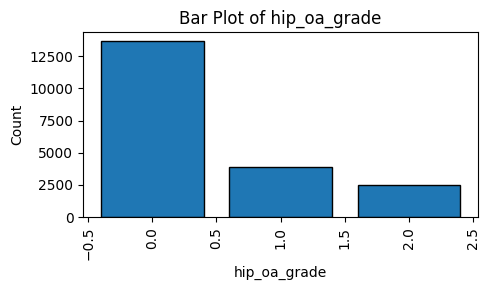

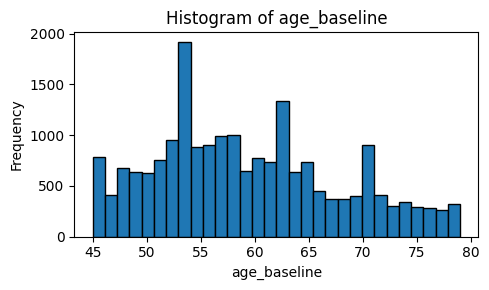

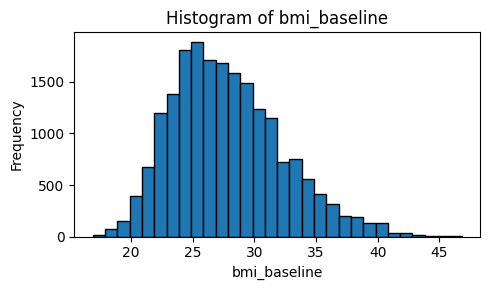

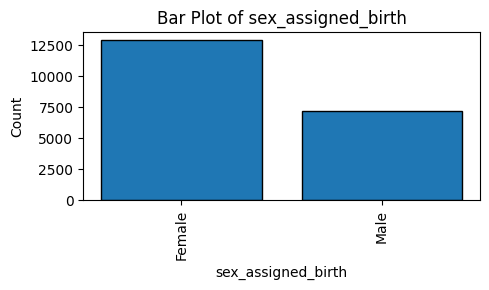

In [6]:
def visualize_dataframe(df):
    """
    This function takes a pandas DataFrame and plots a histogram for numerical columns
    and a bar plot for categorical columns using only matplotlib.
    """
    for column in df.columns:
        plt.figure(figsize=(5, 3))
        
        if pd.api.types.is_numeric_dtype(df[column]):
            plt.hist(df[column].dropna(), bins=30, edgecolor='k')
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.title(f'Histogram of {column}')
        
        elif pd.api.types.is_categorical_dtype(df[column]) or df[column].dtype == object:
            counts = df[column].value_counts()
            plt.bar(counts.index, counts.values, edgecolor='k')
            plt.xlabel(column)
            plt.ylabel('Count')
            plt.title(f'Bar Plot of {column}')
            plt.xticks(rotation=90)  # Rotate x-axis labels if necessary
        
        plt.tight_layout()
        plt.show()

df_train['hip_oa_grade'] = df_train['hip_oa_grade'].astype('category')
visualize_dataframe(df_train[['hip_oa_grade', 'age_baseline', 'bmi_baseline', 'sex_assigned_birth']])

In [13]:
# reminder to balance training set on grade and sex, which are unbalanced

# Data preprocessing

In [7]:
df_train['dicom_image_full_path'] = df_train['dicom_image'].apply(
    lambda file: os.path.join(main_dir, img_folder, file)
)

In [187]:
def load_dicom_image(file_path, img_size=(550, 320)):
    """
    Function to load a DICOM file and convert it to a usable format for TensorFlow.
    Parameters:
        - file_path: The path to the DICOM image file
        - img_size: Desired image size to resize to (default is 128x128)
    Returns:
        - img_array: A preprocessed image in numpy array form
    """
    # Load the DICOM file
    dicom_data = pydicom.dcmread(file_path)
    
    # Get the pixel data from the DICOM file
    img = dicom_data.pixel_array

    img_size = img.shape
    
    # Normalize the pixel values to the range [0, 1]
    img = img.astype(np.float32) / np.max(img)

    #get pixel distances
    source_pixel_spacing = dicom_data.get('PixelSpacing') or dicom_data.get('ImagerPixelSpacing')
    assert source_pixel_spacing is not None, 'no pixel spacing found'
    assert source_pixel_spacing[0] == source_pixel_spacing[1], 'asymmetric pixel spacing is untested'
    pixel_spacing = source_pixel_spacing

    #downscaling
    target_pixel_spacing = 0.7
    
    scale_factor = source_pixel_spacing[0] / target_pixel_spacing
    
    img_resized = skimage.transform.rescale(img, scale_factor)

    # Print shape after rescale
    #print("Shape after rescale:", img_resized.shape)

    img_resized = skimage.transform.resize(img_resized, (550, 320), anti_aliasing=True)

    # Print shape after final resize
    #print("Final image shape:", img_resized.shape)

    photometric_interpretation = dicom_data.get('PhotometricInterpretation')
    if photometric_interpretation == 'MONOCHROME1':
        #print('Photometric interpretation MONOCHROME1: inverting intensities')
        img_resized = np.max(img_resized) - img_resized
    else:
        assert photometric_interpretation == 'MONOCHROME2',\
            f'{photometric_interpretation} not supported'

    # other checks
    assert dicom_data.get('VOILUTFunction', 'LINEAR') == 'LINEAR', \
        'only supporting VOILUTFunction LINEAR'
    
    #return img_pixels, pixel_spacing

    #if img_resized.ndim == 2:  # Grayscale image
        #img_resized = np.stack((img_resized,) * 3, axis=-1)

    #img_resized = tf.image.resize(img_resized, img_size)
    
    pixel_spacing = [target_pixel_spacing, target_pixel_spacing]
    
    # Convert the image to an array format that Keras understands
    img_array = img_to_array(img_resized)

    return img_array

In [188]:
def load_dataset(file_paths, img_size=(550, 320)):
    """
    Load all DICOM images from a list of file paths and convert them to numpy arrays.
    Parameters:
        - file_paths: List of file paths for DICOM images
        - img_size: Desired image size (default is 128x128)
    Returns:
        - X_data: Numpy array of images
    """
    images = []
    for file_path in file_paths:
        img_array = load_dicom_image(file_path, img_size=(550, 320))
        images.append(img_array)
    return images

In [209]:
# Example usage: Assume X_train is a list of DICOM file paths
# X_train = ['path_to_dicom1.dcm', 'path_to_dicom2.dcm', ...]

X_train_images = load_dataset(df_train['dicom_image_full_path'][0:100], img_size=(390, 240))

# Convert the list of images to a numpy array
X_train_images = np.array(X_train_images)

#X_train_images = load_dataset(X_train, img_size=(128, 128))

# If you have labels, prepare y_train accordingly (e.g., binary or multi-class labels)
# y_train = np.array([...])

In [210]:
X_train_images.shape

(100, 550, 320, 1)

In [211]:
X_data[1].shape

(550, 320, 1)

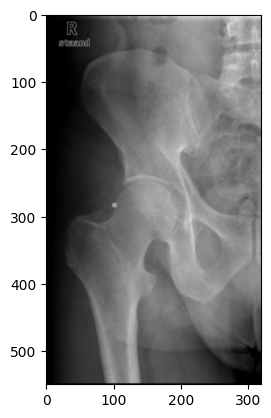

In [212]:
plt.imshow(X_data[1], 'gray')

In [11]:
#dill.dump_session('/trinity/home/r102809/notebook_env.pkl')

# Load and plot dicom image

Image size: (2590, 1501)
Input pixel spacing: [0.143, 0.143]


Text(0.5, 1.0, 'Original Image')

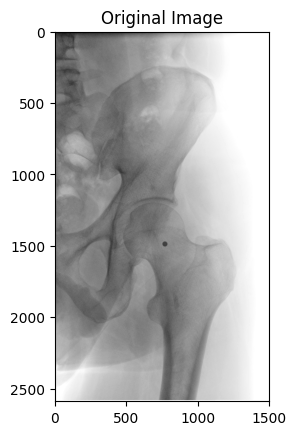

In [11]:

image_file_dicom = os.path.join(main_dir, img_folder, df_train['dicom_image'][0])
img = pydicom.dcmread(image_file_dicom)
print(f"Image size: {img.pixel_array.shape}")

# extract pixel spacing (mm/pixel) from the DICOM headers
source_pixel_spacing = img.get('PixelSpacing') or img.get('ImagerPixelSpacing')
assert source_pixel_spacing is not None, 'no pixel spacing found'
assert source_pixel_spacing[0] == source_pixel_spacing[1], 'asymmetric pixel spacing is untested'
pixel_spacing = source_pixel_spacing
print('Input pixel spacing:', source_pixel_spacing)

plt.imshow(img.pixel_array, 'gray')
#plt.imshow(np.fliplr(img.pixel_array), 'gray')
plt.title('Original Image')

Scaling factor: 0.35749999999999993
Source image size: (2590, 1501)
Resized image size: (926, 537)


Text(0.5, 1.0, 'Resampled Image')

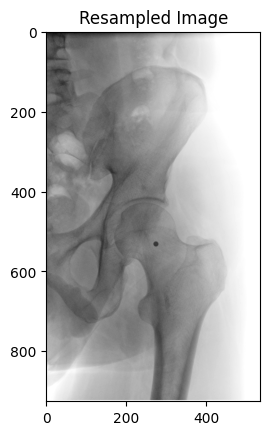

In [12]:
# resample to the required resolution
target_pixel_spacing = 0.4 #example

scale_factor = source_pixel_spacing[0] / target_pixel_spacing
print('Scaling factor:', scale_factor)

print('Source image size:', img.pixel_array.shape)
img_pixels = skimage.transform.rescale(img.pixel_array, scale_factor)
print('Resized image size:', img_pixels.shape)

pixel_spacing = [target_pixel_spacing, target_pixel_spacing]

plt.imshow(img_pixels, 'gray')
plt.title('Resampled Image')

Photometric interpretation MONOCHROME1: inverting intensities


Text(0.5, 1.0, 'Resampled & Processed Image')

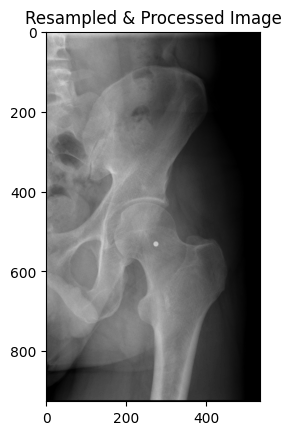

In [13]:
#additional checks on image intensities

# are the intensities stored as MONOCHROME2 (white=max, black=min) or
# as MONOCHROME1 (white=min, black=max)?
photometric_interpretation = img.get('PhotometricInterpretation')
if photometric_interpretation == 'MONOCHROME1':
    print('Photometric interpretation MONOCHROME1: inverting intensities')
    img_pixels = np.max(img_pixels) - img_pixels
else:
    assert photometric_interpretation == 'MONOCHROME2',\
        f'{photometric_interpretation} not supported'

# other checks
assert img.get('VOILUTFunction', 'LINEAR') == 'LINEAR', \
    'only supporting VOILUTFunction LINEAR'

plt.imshow(img_pixels, 'gray')
plt.title('Resampled & Processed Image')

In [14]:
# Processing function
def scale_and_check_dicom_image(img, target_pixel_spacing):
    source_pixel_spacing = img.get('PixelSpacing') or img.get('ImagerPixelSpacing')
    assert source_pixel_spacing is not None, 'no pixel spacing found'
    assert source_pixel_spacing[0] == source_pixel_spacing[1], 'asymmetric pixel spacing is untested'

    scale_factor = source_pixel_spacing[0] / target_pixel_spacing
    img_pixels = skimage.transform.rescale(img.pixel_array, scale_factor)
    pixel_spacing = [target_pixel_spacing, target_pixel_spacing]
    
    photometric_interpretation = img.get('PhotometricInterpretation')
    if photometric_interpretation == 'MONOCHROME1':
        print('Photometric interpretation MONOCHROME1: inverting intensities')
        img_pixels = np.max(img_pixels) - img_pixels
    else:
        assert photometric_interpretation == 'MONOCHROME2',\
            f'{photometric_interpretation} not supported'

    # other checks
    assert img.get('VOILUTFunction', 'LINEAR') == 'LINEAR', \
        'only supporting VOILUTFunction LINEAR'
    
    return img_pixels, pixel_spacing



## Load and visualize images of 10 randomly selected train samples 

Photometric interpretation MONOCHROME1: inverting intensities
Photometric interpretation MONOCHROME1: inverting intensities


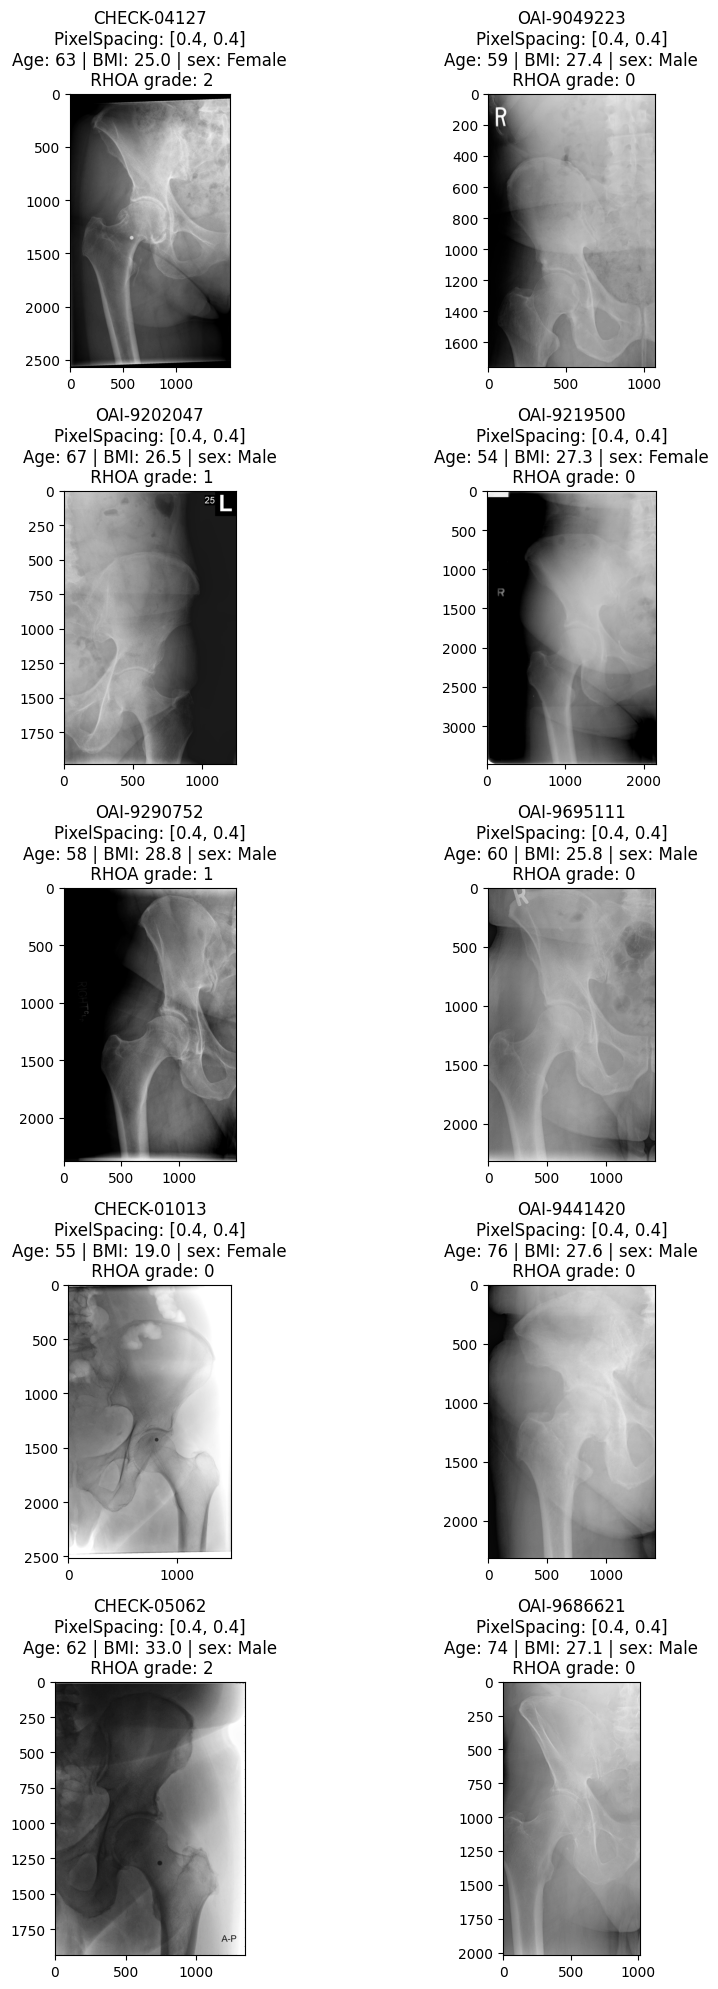

In [15]:
#select 10 samples randomly
df_train_subset10 = df_train.sample(n=10).reset_index()

#create plot for visualisation
fig, ax = plt.subplots(5,2, figsize=(10, 20))
axes = ax.ravel()

#loop over subset of train samples

for index, row in df_train_subset10.iterrows():
    img = pydicom.dcmread(os.path.join(main_dir, img_folder, row['dicom_image']))
    img_pixels, pixel_spacing = scale_and_check_dicom_image(img, 0.4)
    axes[index].imshow(img.pixel_array, 'gray')
    
    axes[index].set_title(f"{row['subject_id']}\nPixelSpacing: {pixel_spacing}\nAge: {row['age_baseline']} | BMI: {row['bmi_baseline']} | sex: {row['sex_assigned_birth']}\n RHOA grade: {row['hip_oa_grade']}")
fig.tight_layout()
fig.show()

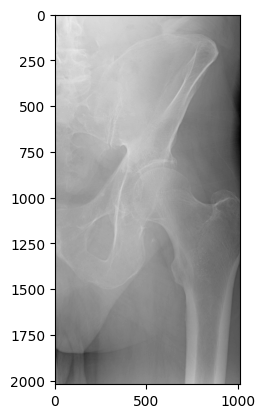

In [16]:
# flipping hip for consistency
#df_train[df_train["hip_side"]=="left"]

#code to flip horizontally
plt.imshow(np.fliplr(img.pixel_array), 'gray')

# dividing available data into training and test set


In [253]:
y_train = df_train["hip_oa_grade"][0:100]
X_train_images
X_train = df_train[["dicom_image", "visit","age_baseline","bmi_baseline","sex_assigned_birth"]][0:100]

In [254]:
stratify_labels = [f"{sex}_{grade}" for sex, grade in zip(X_train["sex_assigned_birth"], y_train)]

In [255]:
X_train, X_test, y_train, y_test = train_test_split(X_train_images, y_train, test_size=0.2, 
                                                    stratify=stratify_labels, random_state=42)

In [23]:
#y_train_cat = tf.keras.utils.to_categorical(y_train, 4)
#y_test_cat = tf.keras.utils.to_categorical(y_test, 4)

In [24]:
#model = models.Sequential()

In [31]:
#np.unique(y_train, return_counts=True)

(array([0, 1, 2]), array([467, 230, 103]))

In [26]:
#print(f"Shape of input images: {X_train.shape}")
#print(f"Shape of output labels (one-hot encoded): {y_train.shape}")

Shape of input images: (16076, 5)
Shape of output labels (one-hot encoded): (16076,)


# GPU setup

In [12]:
import tensorflow as tf

# List available devices
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Check for available GPUs
if tf.config.list_physical_devices('GPU'):
    print("GPU is available for TensorFlow!")
else:
    print("GPU is not available for TensorFlow, check your installation.")

Num GPUs Available:  1
GPU is available for TensorFlow!


I0000 00:00:1726927267.573793   21057 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726927267.601983   21057 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726927267.602735   21057 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [13]:
#pip install tensorflow[and-cuda]

In [14]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [15]:
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow is using the GPU!")
else:
    print("TensorFlow is using the CPU.")

TensorFlow is using the GPU!


In [16]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Set model

In [216]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
#from keras.preprocessing.image import ImageDataGenerator

import numpy as np

import keras, os

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten

import matplotlib.pyplot as plt

In [204]:
# Reshape images to 3D for keras imput (if you have not already) 
#X_train = np.expand_dims(X_train, axis=3)
# do the same for test_images 



#X_test = np.expand_dims(X_test, axis=3)
# do the same for test_images 





In [256]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3) # just turns vector labels to a 1-hot array, not sure if you need it but probably 

y_test = tf.keras.utils.to_categorical(y_test, num_classes=3) # just turns vector labels to a 1-hot array, not sure if you need it but probably 

In [220]:
X_train.shape
X_train_images.shape

(100, 550, 320, 1)

In [257]:
_, img_dim1, img_dim2, img_dim3 = X_train.shape

In [261]:
# Simple CNN model 

# Hyperparameters (PLAY KIDS, PLAY)
num_filters = 8 
filter_size = 3
pool_size = 2

activation_inner, activation_outer = 'relu', 'softmax' # 'sigmoid'

# Sequential stacks the layers together 
cnn_model = tf.keras.Sequential([
    
    # First Convolution and Pooling Layers
    tf.keras.layers.Conv2D(num_filters, filter_size, 
                           input_shape=(img_dim1, img_dim2, img_dim3),
                           activation=activation_inner),
    tf.keras.layers.MaxPooling2D(pool_size=pool_size),
    # tf.keras.layers.BatchNormalization()
    
    # Add second convolution and pooling Layers (try without first)
    # tf.keras.layers.Conv2D(num_filters2, filter_size2, activation=activation_inner),
    # tf.keras.layers.MaxPooling2D(pool_size=pool_size2), 

    # Dropout example
    tf.keras.layers.Dropout(0.2), # Nice for preventing overfitting 

    tf.keras.layers.Flatten(), 
    # Can add more Dense layers here too often done
    tf.keras.layers.Dense(3, activation=activation_outer), # 2 categories no? 
])

cnn_model.summary()
#tf.keras.utils.plot_model(cnn_model, show_shapes=True)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 548, 318, 8)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 274, 159, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 274, 159, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 348528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │     1,045,587 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,045,667 (3.99 MB)

 Trainable params: 1,045,667 (3.99 MB)

 Non-trainable params: 0 (0.00 B)

In [262]:
# Compile

optimizer = 'adam' # this is usually quite good, I would not touch for now 
loss_func = 'binary_crossentropy' # we have two categories no..? or 'categorical_crossentropy'
# try also tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) for sparse labels
metrics = ['accuracy'] # Can use F1 if you have very unbalanced classes, not sure 

cnn_model.compile(
    optimizer, 
    loss = loss_func,
    metrics=metrics
)

In [263]:
# Training the model

n_epochs = 100 # Iterations, keep this low if you are overfitting, or you can try to rely on the callbacks I define below

# Define some to prevent overfitting callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "cnn_sere.best_epoch.keras", save_best_only=True
)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)


history = cnn_model.fit(
    X_train, 
    y_train, # just turns vector labels to a 1-hot array, not sure if you need it 
    epochs = n_epochs, 
    validation_data=(X_test, y_test),
    callbacks=[checkpoint_cb, early_stopping_cb],
    verbose=2,
)

Epoch 1/100


I0000 00:00:1726934165.948773   22720 service.cc:146] XLA service 0x155414103d40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726934165.948815   22720 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-09-21 17:56:06.334179: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-21 17:56:07.254805: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1726934172.721084   22720 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


ValueError: EarlyStopping callback received monitor=val_acc but Keras isn't able to automatically determine whether that metric should be maximized or minimized. Pass `mode='max'` in order to do early stopping based on the highest metric value, or pass `mode='min'` in order to use the lowest value.

In [222]:
def build_cnn_model(input_shape):
    """
    Build a simple CNN model using TensorFlow/Keras.
    Parameters:
        - input_shape: The shape of the input images (height, width, channels)
    Returns:
        - model: A compiled Keras CNN model
    """
    model = Sequential()

    # Convolutional layer 1
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional layer 2
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the output from convolutional layers
    model.add(Flatten())

    # Fully connected layer
    model.add(Dense(128, activation='relu'))

    # Output layer (for binary classification, use sigmoid; for multi-class, use softmax)
    model.add(Dense(1, activation='sigmoid'))  # Change to softmax for multi-class

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Get the shape of the input images
input_shape = (550, 320, 1)  # Assuming grayscale images, change to 3 for RGB

# Build and compile the model
model = build_cnn_model(input_shape)

# Summary of the model
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 548, 318, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 274, 159, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 272, 157, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 136, 78, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 678912)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    86,900,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,919,809 (331.57 MB)

 Trainable params: 86,919,809 (331.57 MB)

 Non-trainable params: 0 (0.00 B)

In [229]:
y_train.shape

(80, 3)

In [230]:
y_test.shape

(20, 3)